# Five-arm Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on three arms which are placed approximately 120 degrees apart.  This notebook will use measurements to infer the actual layout of the antennas.

Arm 1 will point geographically north (NOT magnetic). This arm forms the y-axis and will be used as a reference. We will assume that the x positions along this arm are approximately zero.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]
global_rot_degrees = -35.07826156287494

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

#pd.read_excel('three_arm_measurements.ods', engine='odf')
cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      695.0
A 1     2555.0
A 2     1120.0
A 3     2045.0
A 4     1730.0
A 5     1813.0
A 6     2575.0
A 7      260.0
A 8      565.0
A 9      943.0
A 10    2565.0
A 11     680.0
A 12    1530.0
A 13    1204.0
A 14    1944.0
A 15     875.0
A 16    2570.0
A 17     350.0
A 18    2285.0
A 19    1280.0
A 20    2530.0
A 21    2233.0
A 22    1810.0
A 23    1283.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[   0., 1855.,  419., 1345., 1030., 1732., 2448.,  665.,  748.,
         985., 3157., 1310., 2135., 1822., 2543., 1495., 3165., 1005.,
        2883., 1890., 2402., 2120., 1724., 1253.],
       [1855.,   nan,   nan,   nan,   nan,   nan, 3018.,   nan,   nan,
          nan, 4872.,   nan,   nan,   nan,   nan,   nan, 4879.,   nan,
          nan,   nan, 2975.,   nan,   nan,   nan],
       [ 419.,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 1085.,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
        3255.,   nan,   nan,   nan,   nan,   nan],
       [1345.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [1030.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan, 3495.,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [1732.,   nan,   nan,   nan,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import json
import requests

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    with open('rhodes_24_opt.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    print(cal_json)
    arm_angles = np.radians(cal_json['arm_degrees'])
    narms = cal_json['num_arms']
    arms = cal_json['arms']
    current_pos = []
    for arm_angle,arm in zip(arm_angles, arms):
        print(arm_angle, arm)
        r = np.array(arm)
        arm_y = r*np.cos(arm_angle + np.radians(global_rot_degrees))
        arm_x = r*np.sin(arm_angle + np.radians(global_rot_degrees))
        for x,y in zip(arm_x, arm_y):
            current_pos.append([x,y])
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))



{'C/N': 2.158123728118006, 'arm_degrees': [0.0, 72.0, 144.0, 216.0, 288.0], 'arms': [[0.6529630237476174, 2.504432694886343, 1.073494591195416, 2.0005486285280463, 1.693181081287429], [1.7817801673973575, 2.5479706468791354, 0.24027311461115142, 0.5448087496619634, 0.9209845465458897], [2.54993417924799, 0.7030967569347759, 1.5336789571128613, 1.2116849949441444, 1.932751799958924], [0.8609740214161916, 2.5468131744184697, 0.3521255703988069, 2.2409579872406376, 1.2609873402646041], [2.4973866033909307, 2.191993817667368, 1.7956789837968319, 1.2717328395565333]], 'entropy': 3.8594732373100027, 'fov_degrees': 160.0, 'num_arms': 5, 'penalty': 0.05830674870939684, 'radius': 2.55, 'radius_lower': 0.20000000298023224, 'res_arcmin': 180.0, 'spacing': 0.30000001192092896}
0.0 [0.6529630237476174, 2.504432694886343, 1.073494591195416, 2.0005486285280463, 1.693181081287429]
1.2566370614359172 [1.7817801673973575, 2.5479706468791354, 0.24027311461115142, 0.5448087496619634, 0.9209845465458897]
2

-375.2544534831974 534.3639261052887
-1439.2844434147871 2049.547124161789
-616.9317579794641 878.5134280830209
-1149.7048913370284 1637.1846193820534
-973.0623606524271 1385.6449098925718
1070.3573757245865 1424.4562657949634
1530.6260698818426 2036.9924525033825
144.3377275817501 192.0879746404756
327.27946703535474 435.55105804633973
553.2571415718963 736.2873557762844
2412.1418410047527 -826.8833396382613
665.1030914755946 -227.9976476234045
1450.8026180548252 -497.335809022494
1146.2084387152154 -392.92078335310765
1828.3105198947042 -626.7456925155673
-13.850210701827438 -860.8626122774085
-40.96976006995516 -2546.483619454736
-5.664530197441482 -352.0800057179154
-36.04956656668091 -2240.668009618552
-20.285095624922754 -1260.8241698203158
-2387.2631100251733 -733.4266768460413
-2095.3367697317717 -643.739635335582
-1716.4976338245522 -527.3508186438484
-1215.6551530943075 -373.4795362021582


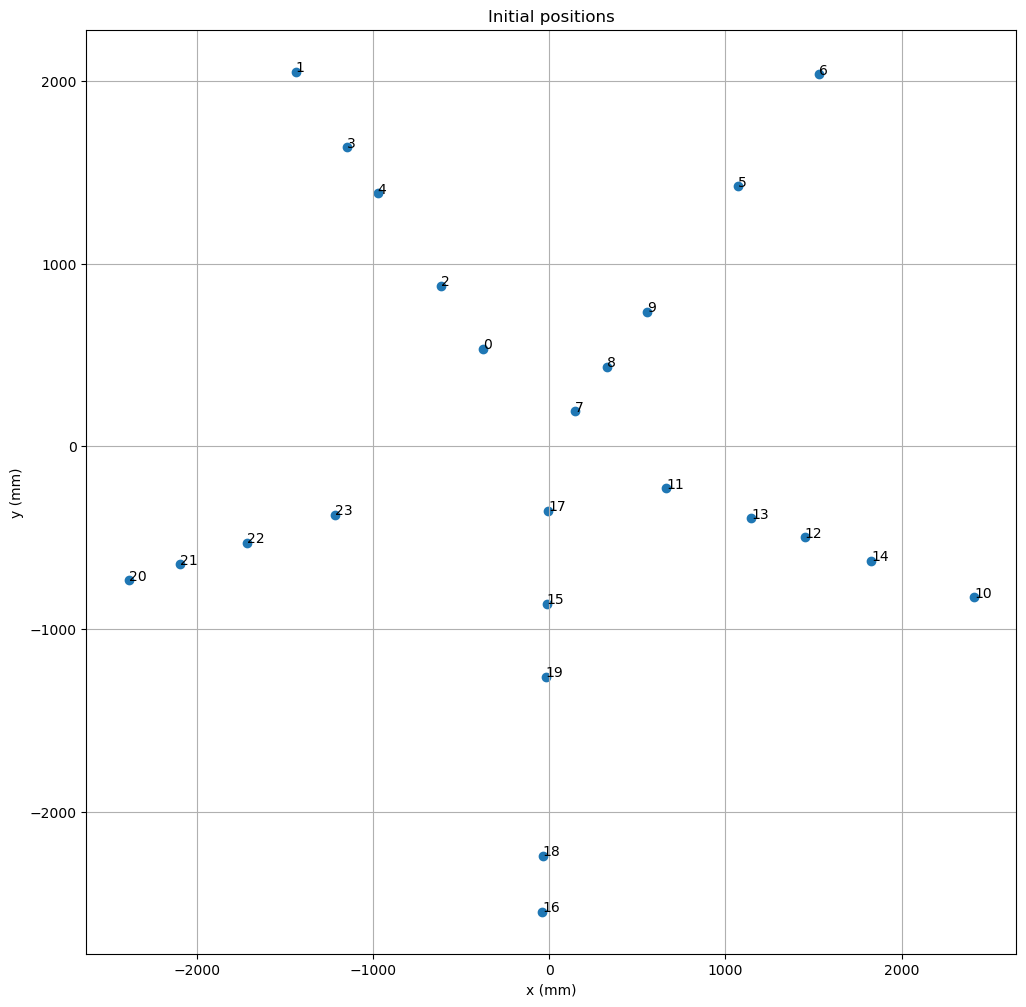

In [7]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [8]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 1200
def bounds():
    ret = [(0,0)]*48
    for i in range(24):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    # x-component of the north arm set to zero.
    #for i in [0,1,2,3,4]:
    #    xval = pos_i[i,0]
    #    ret[i_x(i)] = ( - 2, + 2)
    
    return ret

bnd = bounds()

center = [0,0]

def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij


def f(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    return ret

print(f(initial_guess))

178931.16352158348


We can see that the initial value of this optimality condition is about 600,000.

In [9]:
res = minimize(f, initial_guess, bounds=bnd)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 139.8472300464094
        x: [-4.030e+02  5.717e+02 ... -1.228e+03 -3.711e+02]
      nit: 159
      jac: [ 8.157e-04 -1.305e-03 ... -1.904e-04  2.842e-06]
     nfev: 7987
     njev: 163
 hess_inv: <48x48 LbfgsInvHessProduct with dtype=float64>

In [10]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: 000.00, 	-00.00
Ant 1:	Jac: 000.00, 	000.00
Ant 2:	Jac: -00.00, 	000.00
Ant 3:	Jac: 000.00, 	000.00
Ant 4:	Jac: -00.00, 	000.00
Ant 5:	Jac: -00.00, 	-00.00
Ant 6:	Jac: -00.00, 	-00.00
Ant 7:	Jac: -00.00, 	-00.00
Ant 8:	Jac: 000.00, 	000.00
Ant 9:	Jac: 000.00, 	-00.00
Ant 10:	Jac: 000.00, 	000.00
Ant 11:	Jac: 000.00, 	000.00
Ant 12:	Jac: -00.00, 	-00.00
Ant 13:	Jac: -00.00, 	-00.00
Ant 14:	Jac: -00.00, 	-00.00
Ant 15:	Jac: 000.00, 	000.00
Ant 16:	Jac: 000.00, 	-00.00
Ant 17:	Jac: -00.00, 	000.00
Ant 18:	Jac: -00.00, 	000.00
Ant 19:	Jac: 000.00, 	000.00
Ant 20:	Jac: 000.00, 	-00.00
Ant 21:	Jac: 000.00, 	-00.00
Ant 22:	Jac: 000.00, 	-00.00
Ant 23:	Jac: -00.00, 	000.00


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [11]:
pos = res.x.reshape((24,2))
pos

array([[-4.03030959e+02,  5.71732521e+02],
       [-1.47480830e+03,  2.08793769e+03],
       [-6.52124683e+02,  9.08963249e+02],
       [-1.17511946e+03,  1.67325261e+03],
       [-9.99474221e+02,  1.41167044e+03],
       [ 1.08639380e+03,  1.45575774e+03],
       [ 1.54226314e+03,  2.06011626e+03],
       [ 1.54435642e+02,  2.09164001e+02],
       [ 3.34010442e+02,  4.55973068e+02],
       [ 5.64732004e+02,  7.55199439e+02],
       [ 2.42595064e+03, -8.32620575e+02],
       [ 6.45671839e+02, -2.13328734e+02],
       [ 1.44964553e+03, -4.89312117e+02],
       [ 1.13227765e+03, -4.09344329e+02],
       [ 1.84080583e+03, -6.24951526e+02],
       [-2.48600570e+01, -8.74646474e+02],
       [-4.81355334e+01, -2.57408179e+03],
       [-2.46880556e+00, -3.49991351e+02],
       [-3.08975062e+01, -2.28645731e+03],
       [-1.81889921e+01, -1.27890389e+03],
       [-2.41966338e+03, -7.34024539e+02],
       [-2.13684006e+03, -6.48229415e+02],
       [-1.73159692e+03, -5.26943766e+02],
       [-1.

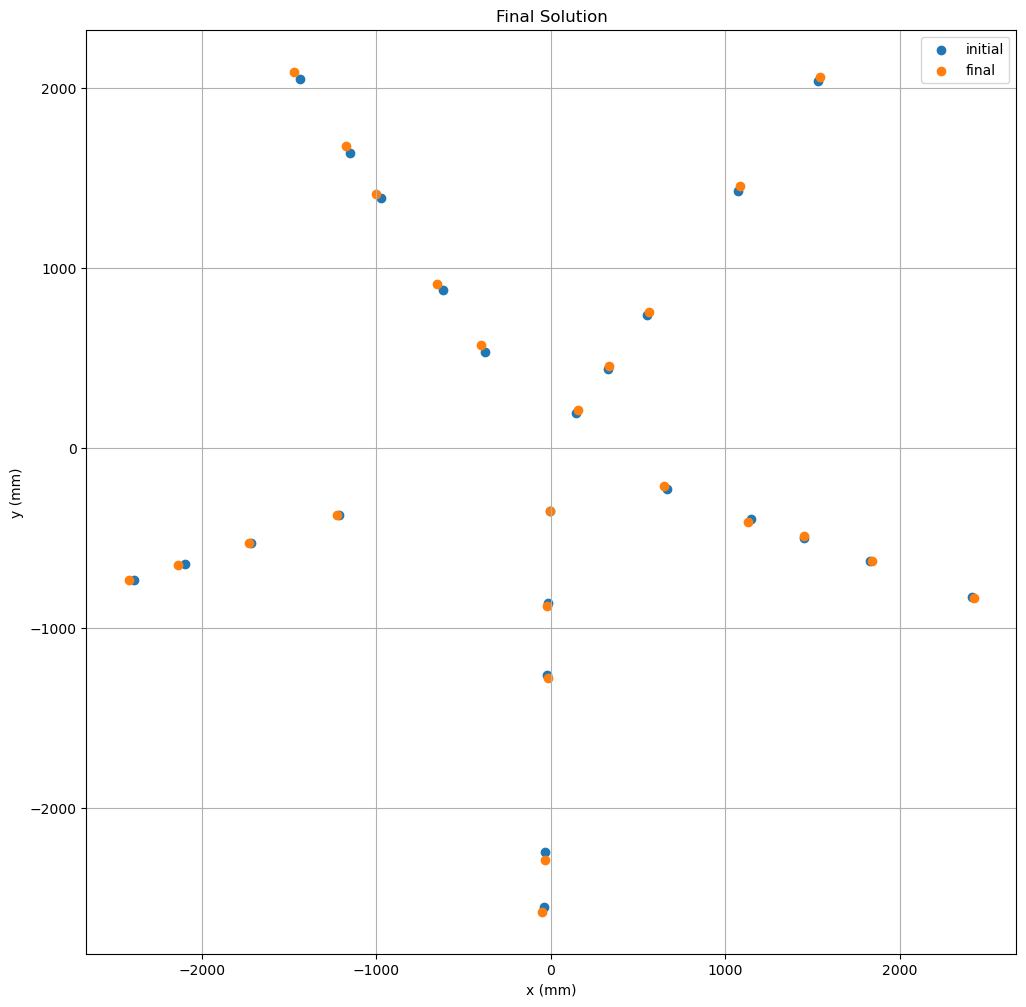

In [12]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial')
ax.scatter(pos[:,0], pos[:,1], label='final')

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

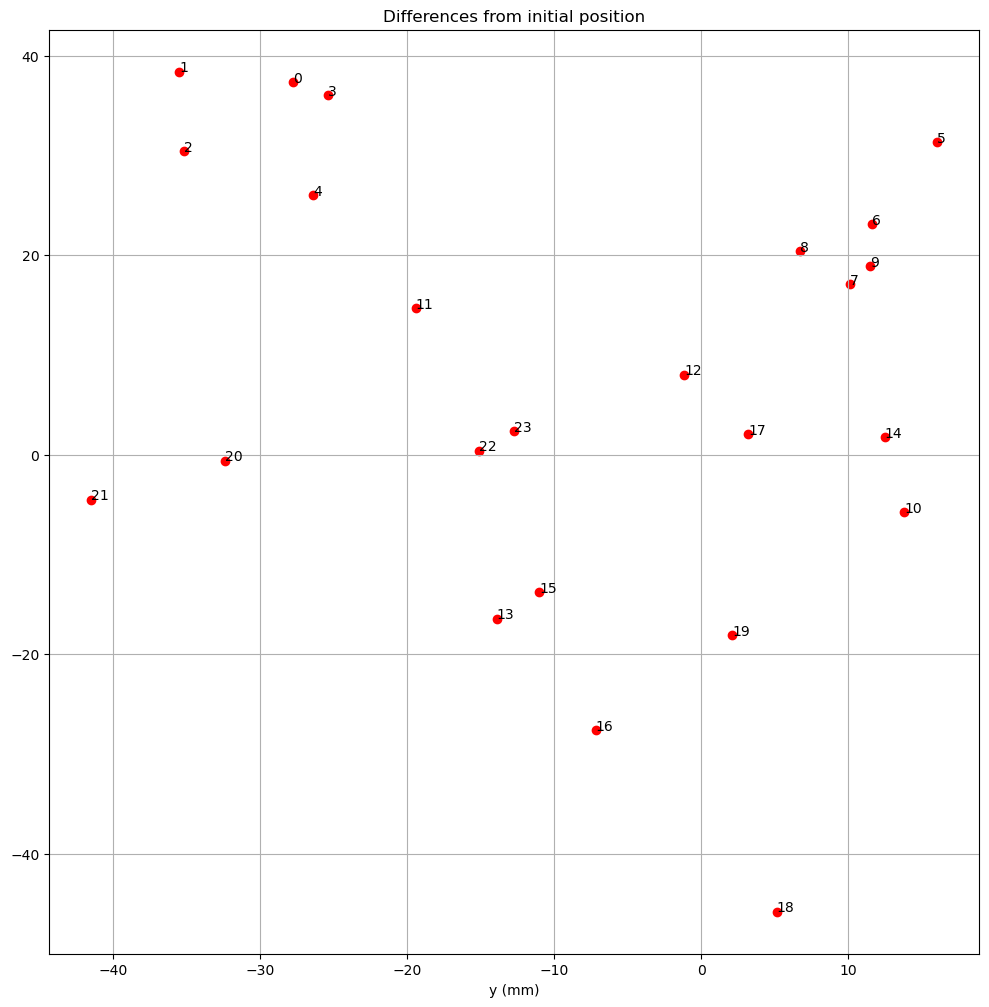

In [13]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [14]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     4.508420
A 1     1.275283
A 2    -1.303978
A 3    -0.328873
A 4    -0.328888
A 5     3.447656
A 6    -1.548114
A 7    -0.000102
A 8     0.220678
A 9    -0.000303
A 10   -0.142589
A 11    0.000936
A 12   -0.000483
A 13   -0.000223
A 14   -0.001408
A 15   -0.000299
A 16    4.531820
A 17    0.000058
A 18    1.666067
A 19   -0.966769
A 20   -1.450438
A 21   -0.000487
A 22   -0.000659
A 23    0.239031
Name: 0, dtype: float64

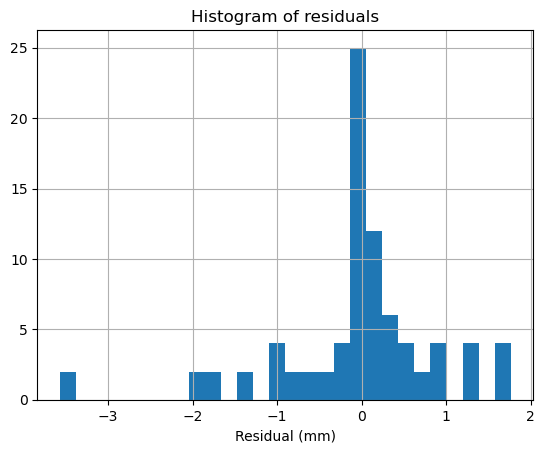

In [15]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [16]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 1.77 mm
 res[0,8] = -1.9
 res[1,16] = -3.6
 res[8,0] = -1.9
 res[16,1] = -3.6


In [17]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-4.030e-01,  5.720e-01,  0.000e+00],
       [-1.475e+00,  2.088e+00,  0.000e+00],
       [-6.520e-01,  9.090e-01,  0.000e+00],
       [-1.175e+00,  1.673e+00,  0.000e+00],
       [-9.990e-01,  1.412e+00,  0.000e+00],
       [ 1.086e+00,  1.456e+00,  0.000e+00],
       [ 1.542e+00,  2.060e+00,  0.000e+00],
       [ 1.540e-01,  2.090e-01,  0.000e+00],
       [ 3.340e-01,  4.560e-01,  0.000e+00],
       [ 5.650e-01,  7.550e-01,  0.000e+00],
       [ 2.426e+00, -8.330e-01,  0.000e+00],
       [ 6.460e-01, -2.130e-01,  0.000e+00],
       [ 1.450e+00, -4.890e-01,  0.000e+00],
       [ 1.132e+00, -4.090e-01,  0.000e+00],
       [ 1.841e+00, -6.250e-01,  0.000e+00],
       [-2.500e-02, -8.750e-01,  0.000e+00],
       [-4.800e-02, -2.574e+00,  0.000e+00],
       [-2.000e-03, -3.500e-01,  0.000e+00],
       [-3.100e-02, -2.286e+00,  0.000e+00],
       [-1.800e-02, -1.279e+00,  0.000e+00],
       [-2.420e+00, -7.340e-01,  0.000e+00],
       [-2.137e+00, -6.480e-01,  0.000e+00],
       [-1

In [18]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

f = open("rhodes_antenna_positions.json", "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            -0.403,
            0.572,
            0.0
        ],
        [
            -1.475,
            2.088,
            0.0
        ],
        [
            -0.652,
            0.909,
            0.0
        ],
        [
            -1.175,
            1.673,
            0.0
        ],
        [
            -0.999,
            1.412,
            0.0
        ],
        [
            1.086,
            1.456,
            0.0
        ],
        [
            1.542,
            2.06,
            0.0
        ],
        [
            0.154,
            0.209,
            0.0
        ],
        [
            0.334,
            0.456,
            0.0
        ],
        [
            0.565,
            0.755,
            0.0
        ],
        [
            2.426,
            -0.833,
            0.0
        ],
        [
            0.646,
            -0.213,
            0.0
        ],
        [
            1.45,
            -0.489,
            0.0
 

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file rhodes_antenna_positions.json
